In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import itertools
from scipy.stats import linregress
import plotly_express as px
import torch.nn.functional as F
import math
import seaborn as sns

In [15]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def find_js_dist_blowup_max_slope(
    js_dists: List[float], min_slope_threshold: float = 0.02
):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    feature_acts = get_feature_activations(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity


def get_feature_activations(sae, steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)

In [11]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [19]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae.eval()

sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


In [ ]:
def interpolate_feature_acts(steps):
    pass

In [5]:
with open("data/clean_metadata.json", "r") as fr:
    metadata = json.load(fr)

activations = np.load("data/clean_activations.npy")

In [125]:
def interpolate_features(steps):
    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(len(steps)):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)
    return interpolated_feature_acts

In [120]:
cos_sim_sae_enc_acts_and_acts = []
cos_sim_interp_acts_and_acts = []

l2_sae_enc_acts_and_acts = []
l2_interp_acts_and_acts = []

n_examples = 5000
idxs = random.sample(range(len(metadata)), n_examples)

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    feature_acts = get_feature_activations(sae, steps)
    acts = torch.tensor(activations[idx])

    start_active_ids = steps[0]["active_feature_ids"]
    start_active_feat_acts = steps[0]["active_feature_acts"]

    end_active_ids = steps[-1]["active_feature_ids"]
    end_active_feat_acts = steps[-1]["active_feature_acts"]

    all_active_feature_ids = list(set(start_active_ids + end_active_ids))
    all_active_feats = {k: {"start": 0, "end": 0} for k in all_active_feature_ids}

    for f_id, f_act in zip(start_active_ids, start_active_feat_acts):
        all_active_feats[f_id]["start"] = f_act

    for f_id, f_act in zip(end_active_ids, end_active_feat_acts):
        all_active_feats[f_id]["end"] = f_act

    interpolated_feature_acts = []

    for i in range(100):
        f_act = torch.zeros(sae.W_enc.shape[1])
        for f_id in all_active_feature_ids:
            f_range = all_active_feats[f_id]
            step_size = (f_range["end"] - f_range["start"]) / 100
            feat_step_act = f_range["start"] + (step_size * i)
            f_act[f_id] = feat_step_act
        interpolated_feature_acts.append(f_act)
    interpolated_feature_acts = torch.stack(interpolated_feature_acts)

    decoded_orig_feat_acts = sae.decode(feature_acts)
    decoded_interpolated_feat_acts = sae.decode(interpolated_feature_acts)

    sim = F.cosine_similarity(decoded_orig_feat_acts, acts).mean().item()
    cos_sim_sae_enc_acts_and_acts.append(sim)

    sim = F.cosine_similarity(decoded_interpolated_feat_acts, acts).mean().item()
    cos_sim_interp_acts_and_acts.append(sim)

    l2_score = torch.norm(acts - decoded_orig_feat_acts, dim=1, p=2).sum().item()
    l2_sae_enc_acts_and_acts.append(l2_score)

    l2_score = (
        torch.norm(acts - decoded_interpolated_feat_acts, dim=1, p=2).sum().item()
    )
    l2_interp_acts_and_acts.append(l2_score)

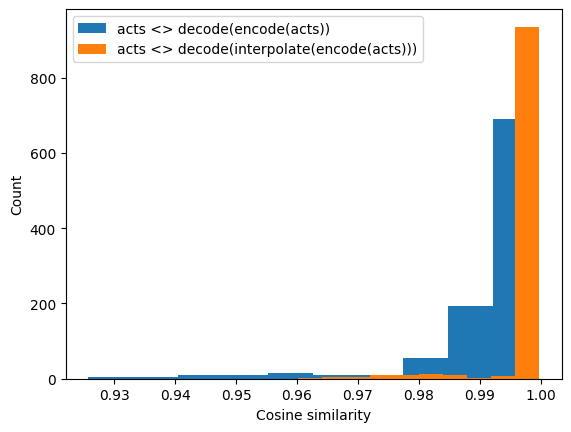

In [118]:
plt.hist(cos_sim_sae_enc_acts_and_acts, label="acts <> decode(encode(acts))")
plt.hist(
    cos_sim_interp_acts_and_acts, label="acts <> decode(interpolate(encode(acts)))"
)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.show()

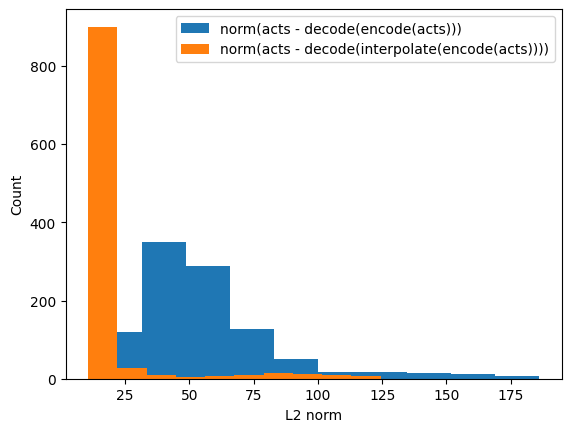

In [119]:
plt.hist(l2_sae_enc_acts_and_acts, label="norm(acts - decode(encode(acts)))")
plt.hist(
    l2_interp_acts_and_acts, label="norm(acts - decode(interpolate(encode(acts))))"
)
plt.xlabel("L2 norm")
plt.ylabel("Count")
plt.legend()
plt.show()